# Get data for points of interest (POIs) to estimate attraction for each zone

There are two ways of fetching data from OpenStreetmap:
* Using overpass queries
* Using locally saved osm.pbf file

Overpass queries take a long time, but work without any further packages. The faster version requires downloading a pbf file for the region of Germany. This is available here (should be saved under `input_static`: https://download.geofabrik.de/europe.html

In [13]:
show_plots = False

In [14]:
import os.path
pbf_file_path = '../../input_static/berlin-latest.osm.pbf'
use_queries = not os.path.exists(pbf_file_path)

In [15]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import numpy as np
from quetzal.model import stepmodel
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

from pyrosm import OSM, get_data
from shapely.geometry import Point, Polygon, LineString

# Disable deprectation warnings caused by libraries
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline

In [16]:
# import helper functions
%run -i helperFunctions.py

In [17]:
model_path = './../../model/'
input_path = './../../input/'

# Number of POIs from OSM data

The extraction from OpenStreetmap makes use of Overpass querys (for documentation see http://osmlab.github.io/learnoverpass/en/docs/). <br>
For trying out querys and their results, use https://overpass-turbo.eu/ (although a success in overpass turbo does not always imply a success in my request). 

For documentation of OpenStreetMap data, see OSM Wiki: https://wiki.openstreetmap.org/.

In [18]:
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
if show_plots: sm.zones.plot()

In [19]:
# Load POI code Excel
poi_codes = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx')
poiKeyVals = poi_codes.loc[(poi_codes['key'].notna()), ['key', 'value']].values
print(poiKeyVals[0:4])
poi_codes.loc[(poi_codes['key'].notna())&(poi_codes['value'].isna()), 'key']

[['amenity' 'college']
 ['amenity' 'school']
 ['amenity' 'university']
 ['building' 'school']]


7    craft
Name: key, dtype: object

## set up new OSM to avoid erorrs when trying to extract POIs

In [20]:
fpb = get_data("Berlin", update=True)
osmb = OSM(fpb)

Downloaded Protobuf data 'Berlin.osm.pbf' (89.06 MB) to:
'C:\Users\BSE\AppData\Local\Temp\pyrosm\Berlin.osm.pbf'


In [21]:
poiKeys = list(filter(lambda x: x == x, poi_codes['key'].unique()))
poiVals = list(filter(lambda x: x == x, poi_codes['value'].unique()))

### extract POIS from OSM

In [22]:
# prepare a list to store dataframes for each query 
pois_arr = []
# get pois data for each key
for key in poiKeys:
    # get all search values for key
    valuesForKey = list(filter(lambda x: x[0] == key, poiKeyVals))
    # if value is NaN, put True (which is the case for key="craft") instead of NaN
    valuesForKey = list(map(lambda x: x[1] if x[1]==x[1] else True, valuesForKey))
    # custom_filter will get all pois with the key and one of the values in valuesForKey
    custom_filter = {key: valuesForKey}
    print(key)
    # get_pois from OSM
    poisForKey = osmb.get_pois(custom_filter=custom_filter)
    # rename column to store value
    poisForKey.index = poisForKey['id']
    poisForKey.rename(columns = { key: 'value' }, inplace = True)
    # create column named key and store the key to
    poisForKey['key'] = key
    # only keep necessary columns
    if not 'value' in poisForKey:
        print("for ", key, "values are", valuesForKey, "values column was missing. Colnames: ", list(poisForKey))
        poisForKey['value'] = valuesForKey[0]
    # add capacity if given, else later use estimate
    if not 'capacity' in poisForKey:
            poisForKey['capacity'] = None

    poisForKey = poisForKey[['key', 'value', 'capacity', 'geometry']]
    # append to df for all keys
    print(poisForKey.head(2))
    pois_arr.append(poisForKey)

# merge pois to one dataframe
pois = pd.concat(pois_arr)
# set crs code correctly
pois = pois.to_crs(epsg = sm.epsg)

amenity
              key       value capacity                   geometry
id                                                               
26735749  amenity  restaurant     None  POINT (13.32287 52.50691)
26735759  amenity  restaurant     None  POINT (13.31808 52.50621)
building
                 key   value capacity  \
id                                      
3363507586  building  school     None   
4703544     building  retail     None   

                                                     geometry  
id                                                             
3363507586                          POINT (13.33420 52.75945)  
4703544     POLYGON ((13.33907 52.52743, 13.33903 52.52741...  
craft
             key     value capacity                   geometry
id                                                            
268915853  craft  cleaning     None  POINT (13.32458 52.47364)
279894354  craft   caterer     None  POINT (13.11071 52.39381)
shop
           key        value capacit

In [23]:
# pois.iloc[list(map(lambda x: x in poiVals, list(pois["value"])))]

In [24]:
if show_plots:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
    pois.plot(ax = ax.flat[0], column = "value", markersize = 2, legend = False)
    pois.iloc[list(map(lambda x: x in poiVals, list(pois["value"])))].plot(ax = ax.flat[1], column = "value", markersize = 2, legend = True)
    ax.flat[0].set_title("Inspect all retrieved POIs")
    ax.flat[1].set_title("Inspect all POIs filtered for matching values")

# match POI information to zones
- prepare zones dataframe to store information about POIs
- then loop through POIs, check in which zone(s) POI lies and 
- add increase the numbers of POIs in that category in that zone by 1

poiCentroid (13.295692840826549, 52.51369627167537) not within polygon for zone 04030417 PLANUNGSRA    Schloßstraße
Name: 04030417, dtype: object
poiCentroid (13.179189246730976, 52.48092543261455) not within polygon for zone 05040934 PLANUNGSRA    Alt-Gatow
Name: 05040934, dtype: object
poiCentroid (13.227973561615071, 52.57807854730849) not within polygon for zone 12224229 PLANUNGSRA    Konradshöhe/Tegelort
Name: 12224229, dtype: object
poiCentroid (13.356104492363187, 52.594944558724436) not within polygon for zone 12302110 PLANUNGSRA    Dannenwalder Weg
Name: 12302110, dtype: object


,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,pop,popCentroidLat,popCentroidLon,emp,pois,...,camp_site,caravan_site,hostel,hotel,theme_park,zoo,lake,geometry,poiCentroid,poiCentroidOffset
index,,,,,,,,,,,,,,,,,,,,,
01011101,Mitte,Stülerstraße,14.06.2006,366755.50,01011101,3406,52.506043,13.347686,8946.424877,23,...,0,0,0,6,0,0,0,"POLYGON ((13.33889 52.50542, 13.33986 52.50562...",POINT (13.34703467072768 52.50606613023518),LINESTRING (13.3474901169085 52.50644478737797...
01011102,Mitte,Großer Tiergarten,14.06.2006,3009397.45,01011102,181,52.512746,13.342029,1335.593976,75,...,0,0,0,1,0,1,1,"POLYGON ((13.33140 52.51288, 13.33141 52.51285...",POINT (13.35119704204171 52.51363876610034),LINESTRING (13.35580435363393 52.5138646855171...
01011103,Mitte,Lützowstraße,14.06.2006,522356.58,01011103,5333,52.503332,13.359626,12188.836098,90,...,0,0,2,7,0,0,0,"POLYGON ((13.34923 52.50307, 13.34972 52.50343...",POINT (13.35981925897393 52.50287087219918),LINESTRING (13.35870186065741 52.5035039075298...


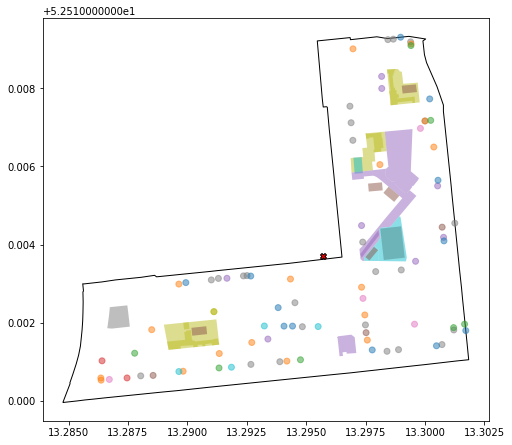

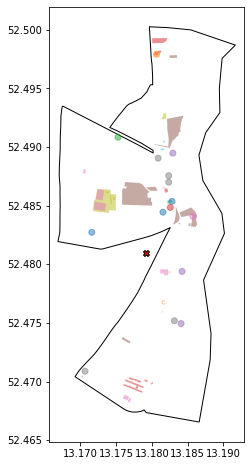

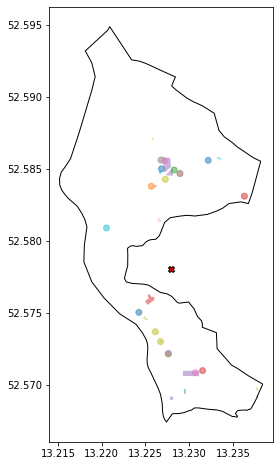

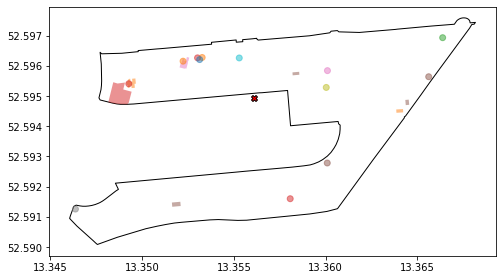

In [25]:
# assign each amenties to one (Points) or (potentially) multiple zones (Polygons)
# this takes a very long time (about 15:00 mins)
t0 = time.time()
# add columns to geodataframe sm.zones to store ammount of amenities
#   - keys
#   - values
sm.zones["pois"] = 0
sm.zones["poiCentroid"] = Point(0,0)
sm.zones["poiCentroidOffset"] = LineString([Point(0,0), Point(0,0)])
sm.zones["poiCentroidLat"] = 0.0
sm.zones["poiCentroidLon"] = 0.0
for keyOrValue in (poiKeys + poiVals):
    sm.zones[keyOrValue] = 0
#

# assign zone to each building
pois['zone'] = \
    pois['geometry']\
        .apply(lambda g: sm.zones.index[sm.zones.intersects(g.centroid)])\
        .apply(lambda zi: zi)

# for each zone assign all POIs
for i in range(len(sm.zones)):
    zone = sm.zones.iloc[i]
    zoneIndex = zone.name

    poisInZone = pois[[zoneIndex in x for x in pois["zone"]]]
    
    # To-Do: imporbe centroid weighting
    
    # obtain total zone population and save to sm.zones
    zonePois = len(poisInZone)
    sm.zones.at[zoneIndex, "pois"] = zonePois
    
    for key in poiKeys:
        sm.zones.at[zoneIndex, key] = len(poisInZone[poisInZone['key'] == key])
    for value in poiVals:
        sm.zones.at[zoneIndex, value] = len(poisInZone[poisInZone['value'] == value])

    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for buildingIndex, building in poisInZone.iterrows():
        weigthedCoords["lon"] += 1 / zonePois * building["geometry"].centroid.x
        weigthedCoords["lat"] += 1 / zonePois * building["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "poiCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "poiCentroidLon"] = weigthedCoords["lon"]
    poiCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not poiCentroid.intersects(zone["geometry"])):
        print("poiCentroid", poiCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone[[x for x in ['PLANUNGSRA', "nam"] if x in zone.keys()]])
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
        sm.zones.iloc[i:i+1].plot(ax=ax, color='None', edgecolor="black")
        poisInZone.plot(ax=ax, column = "value", alpha=0.5)
        GeoSeries([poiCentroid], crs=sm.epsg).plot(ax=ax, color="red", edgecolor="black", marker="X")
    
    sm.zones.loc[zoneIndex, "poiCentroid"] = poiCentroid
    # add a line between actual centroid and poi centroid
    sm.zones.loc[zoneIndex, "poiCentroidOffset"] = LineString([zone["geometry"].centroid, poiCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

               
sm.zones.head(3)

In [26]:
if show_plots:
    # show zones and popCentroids and their offsets from real geometrical centroids
    fig, ax = plt.subplots(1, 1, figsize=(16,16))

    pois[[len(z)>0 for z in pois['zone']]].plot(ax=ax, column='key', cmap = "viridis", alpha=0.5)

    # add zone borders and a bit of opacity
    sm.zones.plot(ax=ax, color = "#ffffff", alpha=0.8)
    sm.zones.plot(ax=ax, color="None", edgecolor="black", linewidth=1)
    nSteps = 20
    cbuff = 10
    cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
    gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
    for i in range(1,nSteps):
        l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.poiCentroidOffset]
        gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
    gpd.GeoSeries(sm.zones.poiCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
    ax.set_title("Zones centroids vs POI weigthed centroids")

## inspect POIs per zone

### For POI keys

In [27]:
if show_plots:
    t0=time.time()
    # Show maps for keys
    clmns = poiKeys
    ncols = 4
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)
    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(18,5*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        # helpers["printProgress"](i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

### For POI values

In [28]:
if show_plots:
    t0=time.time()
    # Show maps for values # takes roughly 5 Minutes
    clmns = poiVals + ["craft"]
    ncols = 5
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)

    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        helpers.printProgress(i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

# How to merge information into a single attractor variable

### How to weight different attractors by number of trips?
- Figure 33 MiD 2017:
    - in %. Verkehrsaufkommen (Wege): 16 Arbeit, 11 dienstlich, 7 Ausbildung, 16 Einkauf,  14 Erledigung, 28 Freizeit, 8 Begleitung
    - in %. Personen-km: 21 Arbeit, 17 dienstlich, 4 Ausbildung, 7 Einkauf,  12 Erledigung, 34 Freizeit, 6 Begleitung
- MiD 2017 Tabelle 8: Durchschnittliche Wegelängen nach Raumtyp [Berlin = Metropole]
    - 12/5 Arbeit, 18/19 dienstlich, 7/5 Ausbildung, 4/4 Einkauf,  9/10 Erledigung, 16/15 Freizeit, 8/6 Begleitung
- Abbildung 34 MiD 2017: Tagesstrecke nach Wegezweck und Raumtyp:
    - 8 Arbeit, 7 dienstlich, 2 Ausbildung, 3 Einkauf, 5 Erledigung, 13 Freizeit, 2 Begleitung
- if demographics matter check Figure 35 MiD differentiated w/r to age and gender
- car ownership in Berlin maybe cross with demographic info per zone
- car kilometers in berlin 


#### maybe add tourism
- 34000000/365=90k+ overnight stays per day.  Mabye do research here.
- OSM key vals: 
    - 'building': 'hotel', 'building:levels':int,
    - 'tourism': 'hostel', 'hotel', 'apartment' 


### Or possibly merge into different attractors variables categorized by how long people are willing to commute to it

In [97]:
sm.zones['university'].sum()

523

In [151]:

anzahl_Wege_POIkeys = pd.read_excel(input_path + 'anzhal-Wege-POIKeys.xlsx')
anzahl_Wege_POIkeys

,Ziel/Zweck,Binnenverkehr,QuellundZielverkehr,AlleWege,POI-keys,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Summe Schule,6.6,3.0,6.3,kindergarten;school;university;college,NaN,NaN,NaN,NaN
1,Summe Einkauf,11.4,6.6,11.2,pharmacy;marketplace;retail;hardware;garden_ce...,NaN,NaN,NaN,NaN
2,Eigener Arbeitsplatz,13.1,18.3,13.4,NaN,NaN,NaN,NaN,NaN
3,Anderer Dienstort/-weg,2.1,6.9,2.5,NaN,NaN,NaN,NaN,NaN
4,Behördengang. Arztbesuch,3.2,1.4,3.1,doctors;clinic;hospital,NaN,NaN,NaN,NaN
5,Dienstleistungseinrichtung (z. B. Post. Bank. ...,2.5,1.1,2.4,roofer;electronics_repair;beekeeper;joiner;pri...,NaN,NaN,NaN,NaN
6,Kultur. Theater. Kino,0.7,0.3,0.7,cinema;arts_centre;theatre;nightclub;events_venue,NaN,NaN,NaN,NaN
7,Gaststätte/Kneipe,3.1,1.5,3.2,restaurant;biergarten;cafe;pub;bar;icecream;ho...,NaN,NaN,NaN,NaN
8,Summe Sport Freizeit,8.7,9.7,8.9,community_centre;public_bath;stadium;beach_res...,NaN,NaN,NaN,NaN
9,Eigene Wohnung,39.2,39.4,38.9,NaN,NaN,NaN,NaN,NaN


In [152]:
# zahlen aus survey
anz_wege_surv = anzahl_Wege_POIkeys['AlleWege'][anzahl_Wege_POIkeys['Ziel/Zweck'] == 'Ungewichtete Fallzahl'][11]
anz_befragte = 40190 


# Faktor zur hochrechnung
faktor_berlin = sm.zones['pop'].sum()/anz_befragte

zwecke = anzahl_Wege_POIkeys['Ziel/Zweck'].values[0:11]
key_string_for_zwecke = anzahl_Wege_POIkeys['POI-keys'].values[0:11]
anz_wege_surv_for_zweck = anzahl_Wege_POIkeys['AlleWege'].values[0:11]

In [153]:
# dictionary von osm tags zu Ziel/Zweck aus SrV servey
poi_to_zweck_dict = {}
zweck_to_poi_dict = {}
for zweck, key_string in zip(zwecke, key_string_for_zwecke):
    zweck_to_poi_dict[zweck] = []
    if(not type(key_string) == str):
        keys = []
    else:
        keys = key_string.rsplit(';')
    keys = [key for key in keys if not key == '']
    # print('keys', keys)
    for key in keys:
        if key in sm.zones.columns:
            zweck_to_poi_dict[zweck].append(key)
            if key in poi_to_zweck_dict.keys():
                print(key, zweck)
                raise('poi key used for more than one zweck!', key, zweck)
            poi_to_zweck_dict[key] = zweck

# print(zweck_to_poi_dict)

In [154]:
# absolute Zahlen Trips je Zweck
zweck_abs_dict = {}

for zweck, p_zweck in zip(zwecke, anz_wege_surv_for_zweck):
    zweck_abs_dict[zweck] = int(p_zweck/100 * anz_wege_surv * faktor_berlin)

zweck_abs_dict


{'Summe Schule': 776548,
 'Summe Einkauf': 1380529,
 'Eigener Arbeitsplatz': 1651705,
 'Anderer Dienstort/-weg': 308153,
 'Behördengang. Arztbesuch': 382110,
 'Dienstleistungseinrichtung (z. B. Post. Bank. Friseur)': 295827,
 'Kultur. Theater. Kino': 86283,
 'Gaststätte/Kneipe': 394437,
 'Summe Sport Freizeit': 1097028,
 'Eigene Wohnung': 4794876,
 'Sonstiges Summe': 1158659}

In [155]:
pois_count_zweck = {}
for zweck in zwecke:
    pois_count_zweck[zweck] = 0
    for key in zweck_to_poi_dict[zweck]:
            pois_count_zweck[zweck] += sm.zones[key].sum()

pois_count_zweck

{'Summe Schule': 6005,
 'Summe Einkauf': 9281,
 'Eigener Arbeitsplatz': 0,
 'Anderer Dienstort/-weg': 0,
 'Behördengang. Arztbesuch': 2024,
 'Dienstleistungseinrichtung (z. B. Post. Bank. Friseur)': 0,
 'Kultur. Theater. Kino': 624,
 'Gaststätte/Kneipe': 9509,
 'Summe Sport Freizeit': 10131,
 'Eigene Wohnung': 0,
 'Sonstiges Summe': 0}

In [156]:
[(key, zweck_abs_dict[key]/pois_count_zweck[key]) for key in pois_count_zweck.keys() if pois_count_zweck[key] > 0]

[('Summe Schule', 129.31690258118235),
 ('Summe Einkauf', 148.7478719965521),
 ('Behördengang. Arztbesuch', 188.7895256916996),
 ('Kultur. Theater. Kino', 138.27403846153845),
 ('Gaststätte/Kneipe', 41.48038700178778),
 ('Summe Sport Freizeit', 108.28427598460172)]

In [158]:
sm.zones['poi_attr_total'] = 0
for zweck in zwecke:
    if pois_count_zweck[zweck] > 0:
        print(zweck)
        sm.zones[zweck] = sm.zones.apply(lambda row: sum([row[key]*zweck_abs_dict[zweck]/pois_count_zweck[zweck] for key in zweck_to_poi_dict[zweck] if key in sm.zones.columns]), axis=1 )
        sm.zones['poi_attr_total'] += sm.zones[zweck]



Summe Schule
Summe Einkauf
Behördengang. Arztbesuch
Kultur. Theater. Kino
Gaststätte/Kneipe
Summe Sport Freizeit


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:07. Minutes remaining: 00:00. 

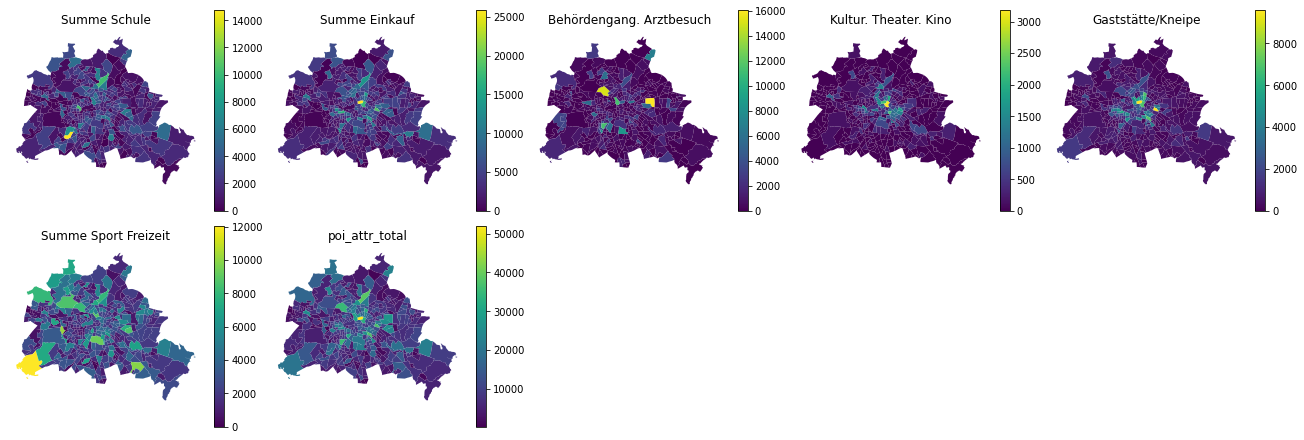

In [159]:
if show_plots:
    t0=time.time()
    # Show maps for values # takes roughly 5 Minutes
    clmns = [z for z in zwecke if z in sm.zones.columns]+['poi_attr_total']
    ncols = 5
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)

    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        helpers.printProgress(i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

### infer about modechoice by demographic characteristics?

### make sure the number of cars returning to a zone matches the number originating from it?

# How to generate OD Matrix from population and POIs

## Save Model

In [ ]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones = sm.zones.drop(columns = [x for x in ['poiCentroid', 'poiCentroidOffset'] if x in sm.zones.columns])


sm.zones = sm.zones.drop(columns = [x for x in keyOrValue if x in sm.zones.columns])

In [ ]:
# Saving table
pois.to_csv(input_path + 'spatial_pois_raw.csv')

In [ ]:
# Saving table
sm.zones.to_csv(input_path + 'spatial_pois_per_zone.csv')

In [ ]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 33/33 [00:02<00:00, 12.04it/s]
